In [58]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from scipy.stats import skew, normaltest, boxcox
from scipy import stats

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import StackingRegressor

In [4]:
df = pd.read_csv("../datasets/admissions.csv")

In [5]:
df.shape

(500, 9)

In [30]:
df = df.drop("Serial No.", axis=1)
df = df.rename(columns={name: name.lower().strip().replace(" ", "_") for name in list(df.columns)})

In [31]:
df.head()

,gre_score,toefl_score,university_rating,sop,lor,cgpa,research,chance_of_admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gre_score          500 non-null    int64  
 1   toefl_score        500 non-null    int64  
 2   university_rating  500 non-null    int64  
 3   sop                500 non-null    float64
 4   lor                500 non-null    float64
 5   cgpa               500 non-null    float64
 6   research           500 non-null    int64  
 7   chance_of_admit    500 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 31.4 KB


In [33]:
df.describe()

,gre_score,toefl_score,university_rating,sop,lor,cgpa,research,chance_of_admit
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


<AxesSubplot:>

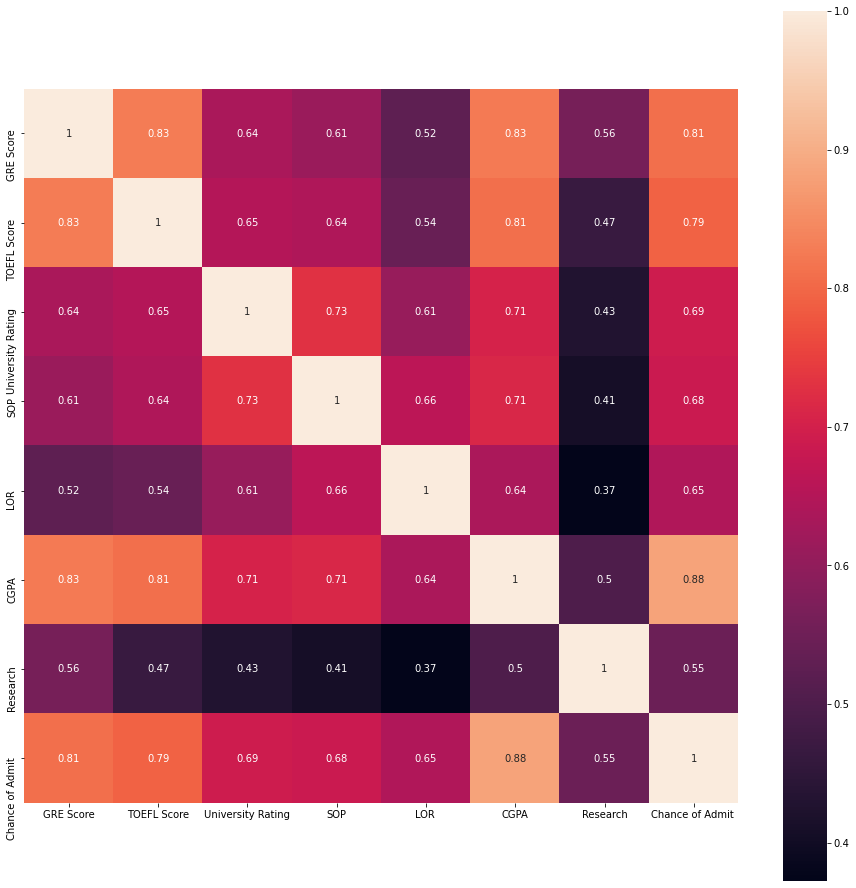

In [14]:
plt.subplots(figsize=(16,16))
sns.heatmap(df.corr(), square=True, annot=True)

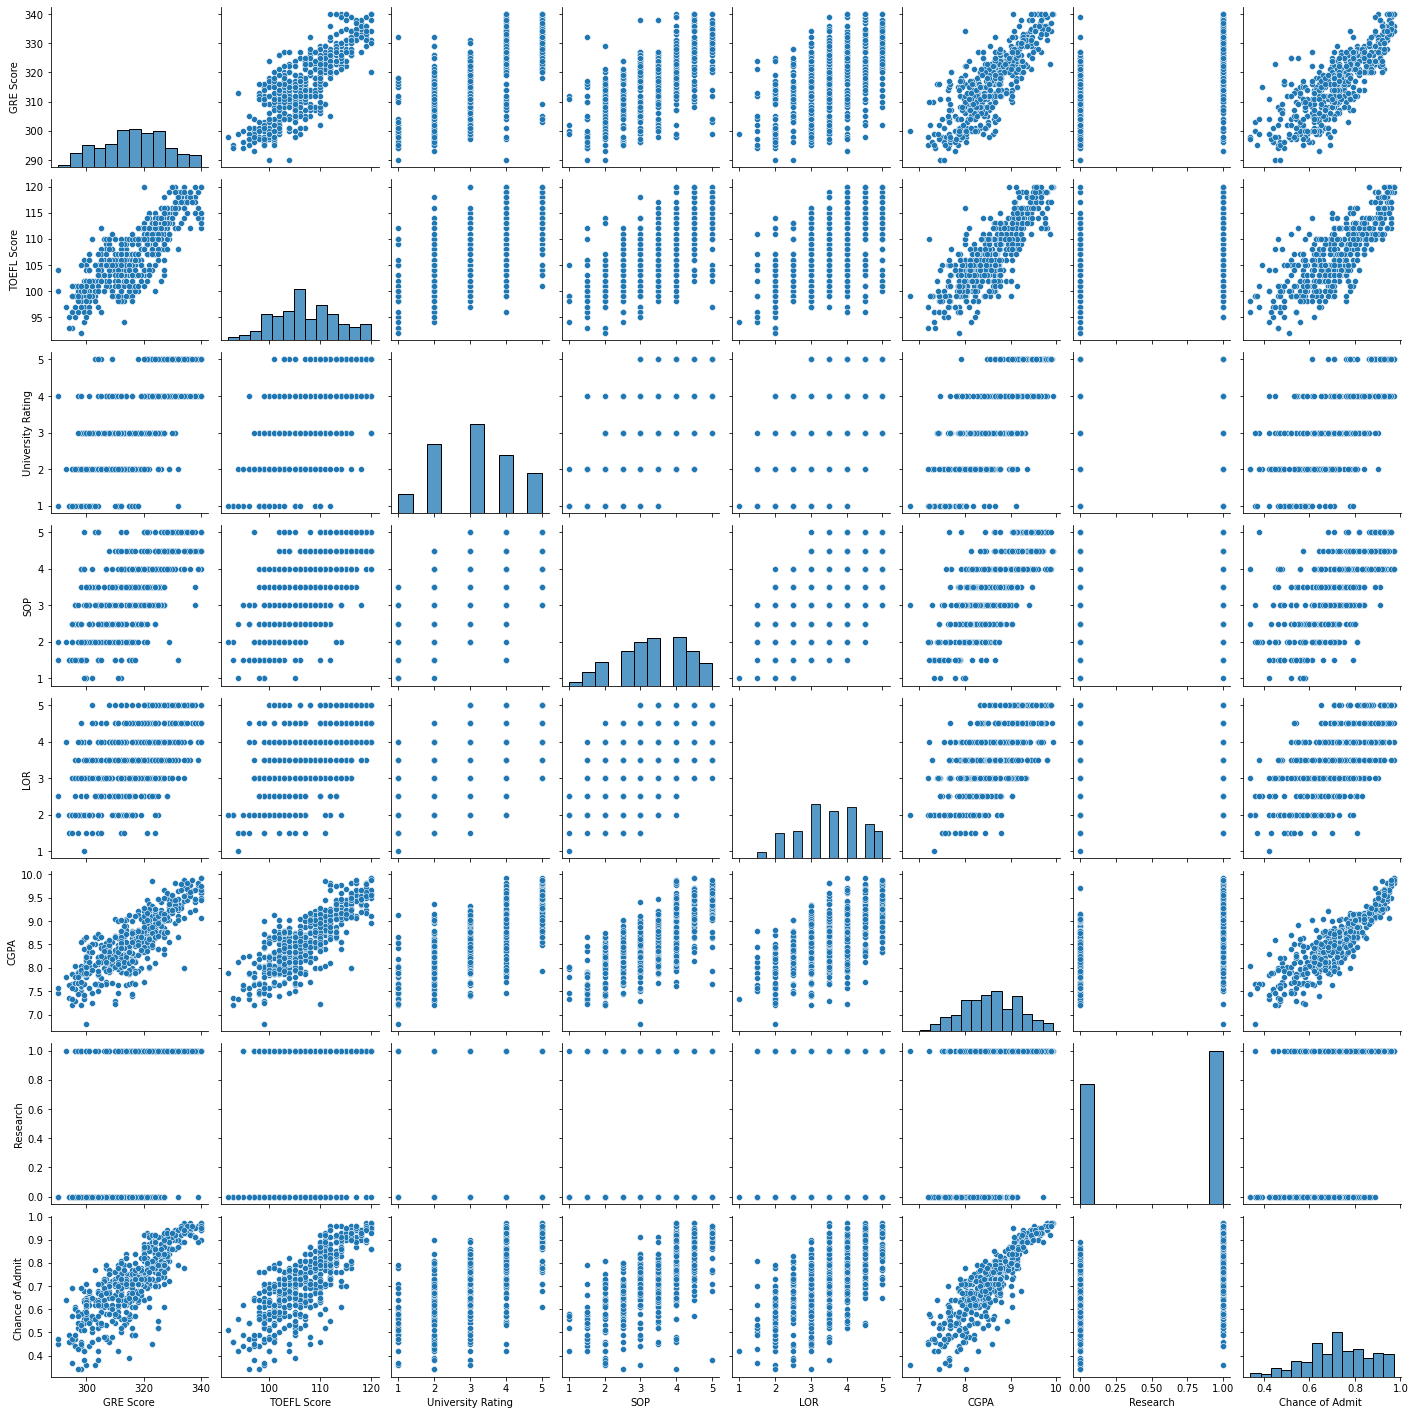

In [19]:
sns.pairplot(df)
# large amount of highly correlated variables: hopefully multicollinearity won't be a problem.

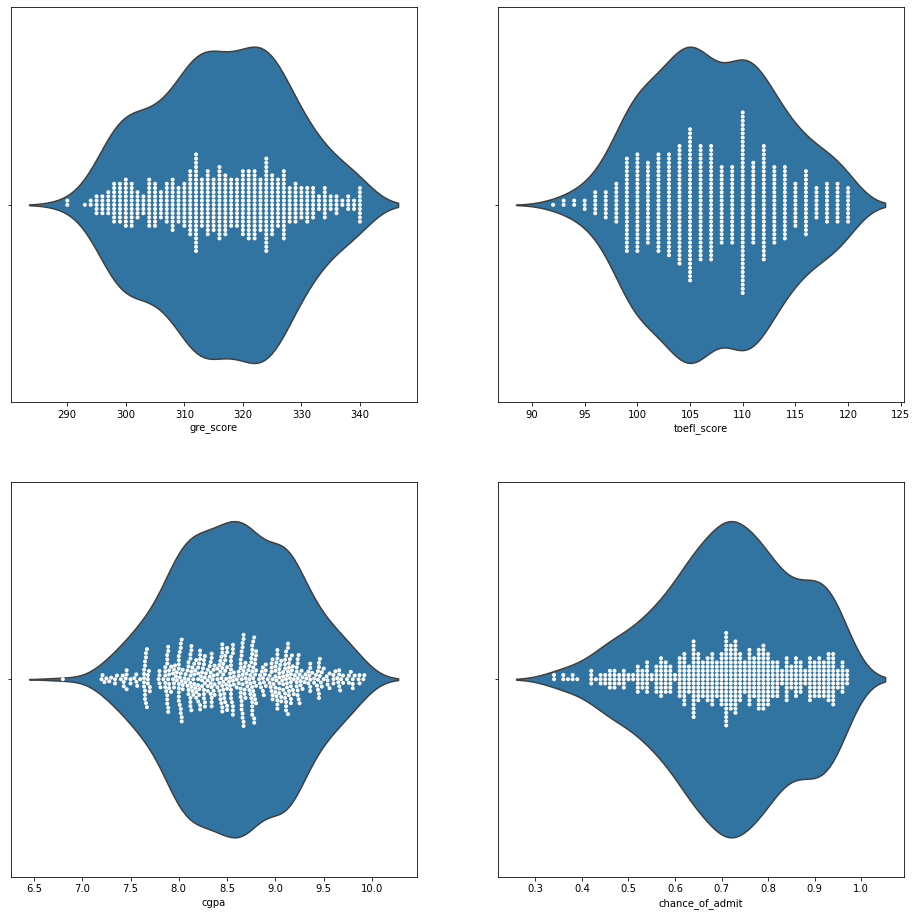

In [35]:
# Now, can view violin/swarm plots of the variables.
cols = ["gre_score", "toefl_score", "cgpa", "chance_of_admit"]

fig, axes = plt.subplots(2, 2, figsize=(16, 16), sharey=False)
for i in range(4):
    sns.violinplot(ax = axes[i // 2][i % 2], x=df[cols[i]], data=df, inner=None)
    sns.swarmplot(ax = axes[i // 2][i % 2], x=df[cols[i]], data=df, color="white", edgecolor="gray", size=4)

<AxesSubplot:xlabel='cgpa', ylabel='Count'>

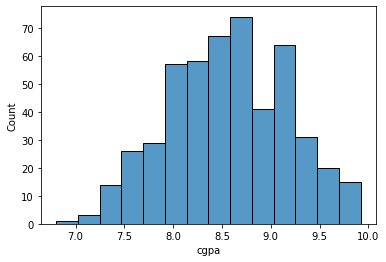

In [51]:
sns.histplot(df["cgpa"])

In [39]:
# check for duplicates
df.duplicated().value_counts()

False    500
dtype: int64

In [43]:
X = df.drop("chance_of_admit", axis=1)
y = df["chance_of_admit"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [44]:
# do we have to transform/normalize any of the data? yes!

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [76]:
def cross_val(model):
    iters = 10
    train_rmse = np.sum(np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = iters)))/iters
    test_rmse = np.sum(np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = iters)))/iters
    return (train_rmse, test_rmse)

def plot_residuals(train_pred, test_pred):
    # plot resiudals
    plt.scatter(train_pred, train_pred - y_train, c = "blue", marker = "s", label = "Training data")
    plt.scatter(test_pred, test_pred - y_test, c = "red", marker = "s", label = "Test data")
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.legend(loc = "upper left")
    plt.hlines(y=0, xmin=0.4, xmax=1, color = "green")
    plt.show()

def plot_predictions(train_pred, test_pred):
    # plot predictions
    plt.scatter(train_pred, y_train, c = "blue", marker = "s", label = "Training data")
    plt.scatter(test_pred, y_test, c = "red", marker = "s", label = "Test data")
    plt.xlabel("Predicted")
    plt.ylabel("Actual Values")
    plt.legend(loc = "upper left")
    plt.plot(color = "green")
    plt.show()

def fit_plot(model):
    train_rmse, test_rmse = cross_val(model)
    print(f"Train rmse: {train_rmse}\nTest rmse: {test_rmse}")
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    score = r2_score(y_test, test_pred)
    print(f"r2 score: {score}")
    plot_residuals(train_pred, test_pred)
    plot_predictions(train_pred, test_pred)
        
def plot_coefs(model):
    coefs = pd.Series(model.coef_, index = list(df.columns)[:-1])
    coefs.sort_values().plot(kind = "barh")
    plt.title("Coefficients in the Lasso Model")
    plt.show()
    
def fit_alpha(model):
    tester = model(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
    tester.fit(X_train, y_train)
    alpha = tester.alpha_

    final = model(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                              alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                              alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], cv = 10)
    final.fit(X_train, y_train)
    alpha = final.alpha_
    plot_coefs(final)
    return final

scorer = make_scorer(mean_squared_error, greater_is_better = False)

Train rmse: 0.5890859848397364
Test rmse: 0.6689823935528323
r2 score: 0.7924556889803502


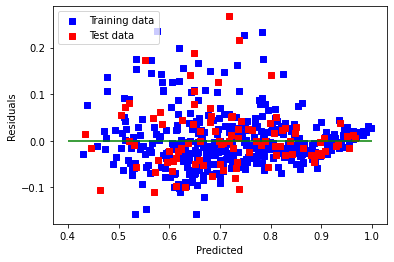

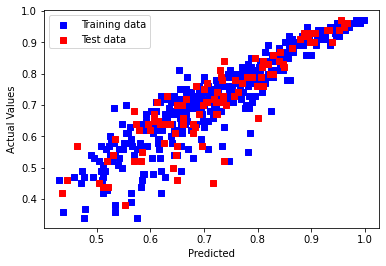

In [77]:
# from the simple linear regression, we can see that the 
lr = LinearRegression()
fit_plot(lr)

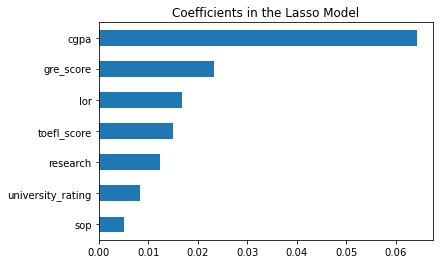

Train rmse: 0.5896869121572614
Test rmse: 0.6702822774600654
r2 score: 0.7908581537689853


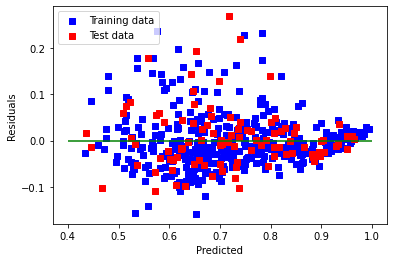

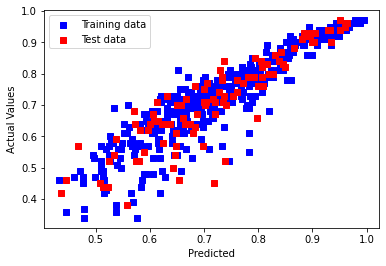

In [79]:
# regularization with linear regression
ridge = fit_alpha(RidgeCV)
fit_plot(ridge)

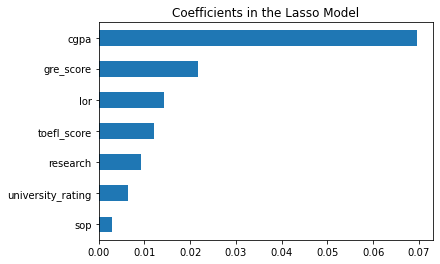

Train rmse: 0.5931864620549867
Test rmse: 0.6611429103844995
r2 score: 0.7912065603259463


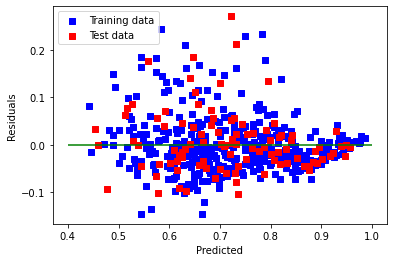

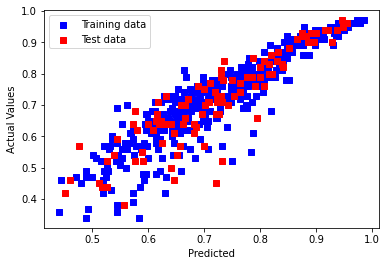

In [80]:
# lasso regularization with linear regression
lasso = fit_alpha(LassoCV)
fit_plot(lasso)

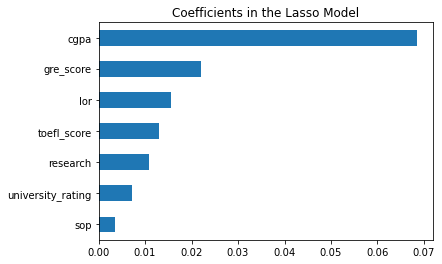

Train rmse: 0.5898530683929046
Test rmse: 0.659087857086451
r2 score: 0.7921908496036123


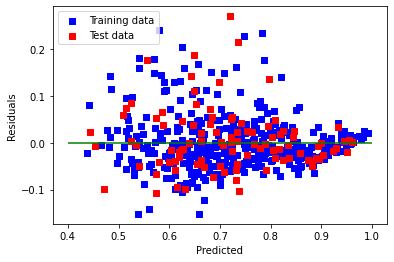

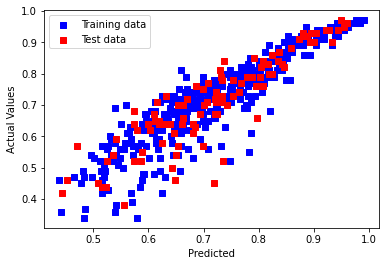

In [81]:
# regularization with elastic net
elastic = fit_alpha(ElasticNetCV)
fit_plot(elastic)

In [82]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

param_tuning = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7],
    'n_estimators' : [100, 200, 500],
    'objective': ['reg:squarederror']
}

xgb_model = xgb.XGBRegressor()

search = RandomizedSearchCV(estimator = xgb_model,
                       param_distributions = param_tuning,
                       scoring = 'neg_mean_squared_error',
                       cv = 10)

search.fit(X_train, y_train)
model_xgb = search.best_estimator_

Train rmse: 0.6064238719467385
Test rmse: 0.6616433345172144
r2 score: 0.7890952871868562


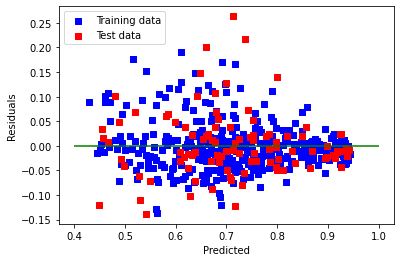

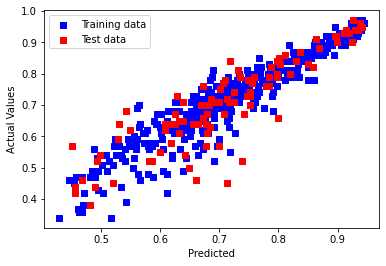

In [83]:
# interesting: compared to last time, xgb doesn't seem to do all that well.
fit_plot(model_xgb)

In [84]:
# let's do a random forest regressor next, with optimized hyperparameters through tuning
from sklearn.ensemble import RandomForestRegressor

rf_params = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

rf_search = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=rf_params, cv=10)
rf_search.fit(X_train, y_train)
rf = rf_search.best_estimator_

Train rmse: 0.6046202287671116
Test rmse: 0.6922692793025347
r2 score: 0.7801690643377033


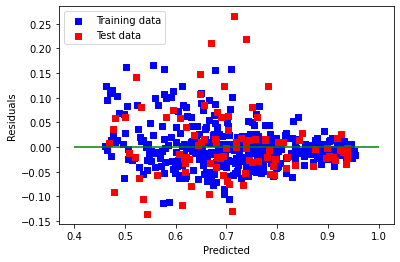

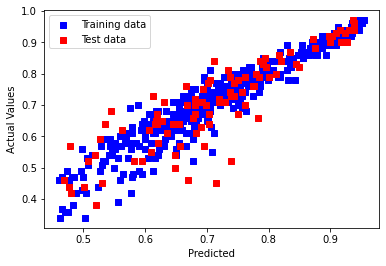

In [85]:
fit_plot(rf)

Train rmse: 0.589046462991412
Test rmse: 0.6898649272105701
r2 score: 0.794432021726081


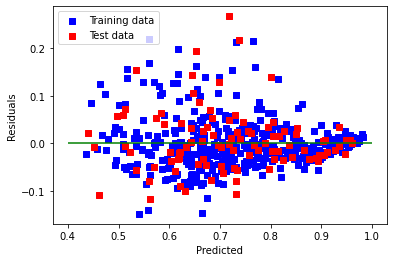

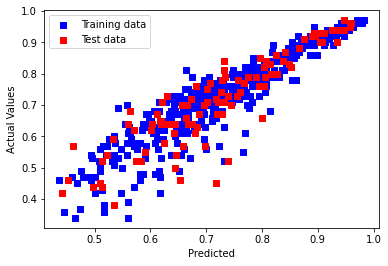

In [86]:
# to end the analysis, let's do a stacked regression
from sklearn.ensemble import StackingRegressor

model_dict = [
    ("lr", lr),
    ("xgb", model_xgb),
    ("lasso", lasso),
    ("ridge", ridge),
    ("elastic", elastic),
]
stacked_model = StackingRegressor(estimators=model_dict, final_estimator=LinearRegression(), cv=5)
fit_plot(stacked_model)
# interestingly, this model seems to perform the best out of all of them!

In [89]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [90]:
# Now, let's try a simple linear regression, but in Tensorflow instead.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train))
print(normalizer.mean.numpy())

[316.0875  106.91      3.065     3.36625   3.49375   8.5493    0.535  ]


In [92]:
first = np.array(X_train[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print('Normalized:', normalizer(first).numpy())

First example: [[321.   112.     5.     5.     5.     9.06   1.  ]]
Normalized: [[0.44 0.84 1.75 1.69 1.63 0.85 0.93]]


In [107]:
def create_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1), # output
    ])
    
    model.compile(loss="mean_absolute_error", optimizer=tf.keras.optimizers.Adam(0.001))
    return model

model = create_model(normalizer)

In [108]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 7)                 15        
_________________________________________________________________
dense_12 (Dense)             (None, 64)                512       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 4,752
Trainable params: 4,737
Non-trainable params: 15
_________________________________________________________________


In [109]:
%%time
history = model.fit(X_train, y_train, validation_split=0.2, verbose=0, epochs=100)

CPU times: user 5.13 s, sys: 270 ms, total: 5.4 s
Wall time: 4.44 s


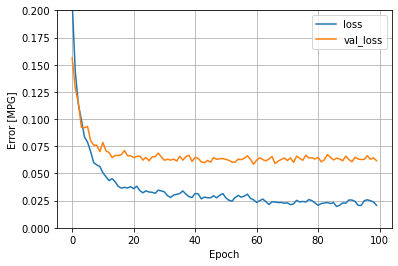

In [110]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, .2])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

plot_loss(history)

# interesting: the graph seems to be shaky and zig-zaggy. Is this evidence of a problem?
# addition, the separation between loss and val_loss seems to be evidence of overfitting.

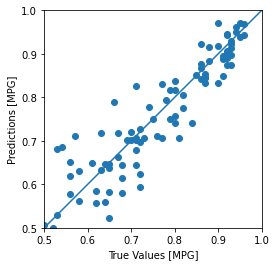

In [115]:
y_pred = model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0.5, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# seems to be a prety close fit.

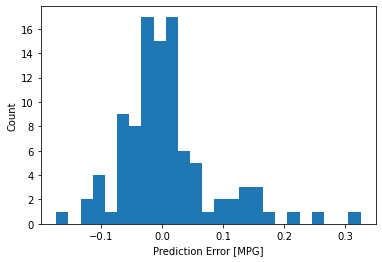

In [116]:
error = y_pred - y_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

# error mostly seems to be centered around 0, but some of the errors are very large compared to actual amounts.

In [117]:
mean_squared_error(y_test, y_pred) # pretty low error compared to the rest of the models!

0.006133637129081703

In [124]:
import tensorflow_addons as tfa

metric = tfa.metrics.r_square.RSquare()
metric.update_state(y_test, y_pred)
result = metric.result()
result.numpy()
# seems to be lower than what we have; with a better model, we might be able to improve this.

0.74895644

In [135]:
def create_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(16, activation="relu"),
        layers.Dense(1), # output
    ])
    
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        0.001,
        decay_steps=1000,
        decay_rate=1,
        staircase=False
    )
    
    model.compile(loss="mean_absolute_error", optimizer=tf.keras.optimizers.Adam(lr_schedule))
    return model

model_small = create_model(normalizer)

In [136]:
%%time
history = model.fit(X_train, y_train, validation_split=0.2, verbose=0, epochs=100)

CPU times: user 5.33 s, sys: 295 ms, total: 5.62 s
Wall time: 4.69 s


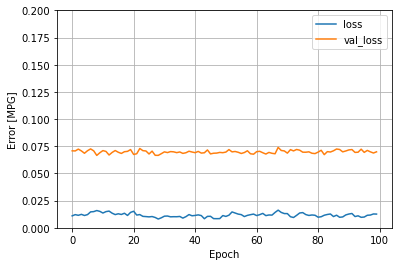

In [137]:
plot_loss(history)

In [138]:
y_pred = model.predict(X_test).flatten()
print(mean_squared_error(y_test, y_pred))

metric = tfa.metrics.r_square.RSquare()
metric.update_state(y_test, y_pred)
result = metric.result()
print(result.numpy())

# A less complex model didn't seem to help us that much at all!

0.007763648659956152
0.6822418
